### Setup

In [1]:
# Loading the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pickle
import shap

### 1.Cargar Datos

#### Variables

1. **ID**
   - Descripción: Identificador único.

2. **N_Days**
   - Descripción: Número de días entre el registro y el anterior a la muerte, trasplante o tiempo de análisis del estudio en julio de 1986.

3. **Status**
   - Descripción: Estado del paciente.
   - Valores:
     - C: Censurado
     - CL: Censurado debido a trasplante de hígado
     - D: Muerte

4. **Drug**
   - Descripción: Tipo de medicamento.
   - Valores:
     - D-penicillamine
     - Placebo

5. **Age**
   - Descripción: Edad en [días].

6. **Sex**
   - Descripción: Sexo del paciente.
   - Valores:
     - M: Masculino
     - F: Femenino

7. **Ascites**
   - Descripción: Presencia de ascitis.
   - Valores:
     - N: No
     - Y: Sí

8. **Hepatomegaly**
   - Descripción: Presencia de hepatomegalia.
   - Valores:
     - N: No
     - Y: Sí

9. **Spiders**
   - Descripción: Presencia de telangiectasias (spiders).
   - Valores:
     - N: No
     - Y: Sí

10. **Edema**
    - Descripción: Presencia de edema.
    - Valores:
      - N: Sin edema y sin terapia diurética para edema
      - S: Edema presente sin diuréticos o edema resuelto por diuréticos
      - Y: Edema a pesar de la terapia diurética

11. **Bilirubin**
    - Descripción: Bilirrubina sérica en [mg/dl].

12. **Cholesterol**
    - Descripción: Colesterol sérico en [mg/dl].

13. **Albumin**
    - Descripción: Albúmina en [gm/dl].

14. **Copper**
    - Descripción: Cobre en orina en [ug/día].

15. **Alk_Phos**
    - Descripción: Fosfatasa alcalina en [U/litro].

16. **SGOT**
    - Descripción: SGOT en [U/ml].

17. **Triglycerides**
    - Descripción: Triglicéridos en [mg/dl].

18. **Platelets**
    - Descripción: Plaquetas por cada [ml/1000].

19. **Prothrombin**
    - Descripción: Tiempo de protrombina en segundos [s].

20. **Stage**
    - Descripción: Etapa histológica de la enfermedad.
    - Valores: 1, 2, 3 o 4.

In [2]:
def cargar_datos(path):
    # Cargar el dataset
    df = pd.read_csv(path)
    
    # Explorar el dataset
    print(f"Tamaño del dataset: {df.shape}")
    print("Tipos de datos por columna:")
    print(df.dtypes)
    
    print("Primeras filas:")
    print(df.head())
    
    print("Porcentaje de valores nulos por columna:")
    valores_nulos_porcentajes = df.isna().mean() * 100
    print(valores_nulos_porcentajes[valores_nulos_porcentajes > 0])
    
    return df

### 2. Visualizacion de Datos 

In [3]:
def plot_histograms(df):
    """
    Genera histogramas para todas las columnas numéricas del DataFrame.
    
    Args:
    df (pd.DataFrame): DataFrame con los datos.
    
    Returns:
    None
    """
    cat_con = df.select_dtypes(include="number").columns.tolist()[1:]
    fig, axes = plt.subplots(4, 3, figsize=(50, 40))
    axes = axes.ravel()
    for col, ax in zip(df[cat_con], axes):
        sns.histplot(x=df[col], ax=ax, bins=30)
        ax.set(title=f'{col}', xlabel=None)
    plt.tight_layout()
    plt.show()


def plot_boxplots(df):
    """
    Genera boxplots para todas las columnas numéricas del DataFrame.
    
    Args:
    df (pd.DataFrame): DataFrame con los datos.
    
    Returns:
    None
    """
    cat_con = df.select_dtypes(include="number").columns.tolist()[1:]
    fig, axes = plt.subplots(4, 3, figsize=(50, 40))
    axes = axes.ravel()
    for col, ax in zip(df[cat_con], axes):
        sns.boxplot(x=df[col], ax=ax)
        ax.set(title=f'{col}', xlabel=None)
    plt.tight_layout()
    plt.show()


def plot_countplots(df):
    """
    Genera gráficos de conteo para todas las columnas categóricas del DataFrame.
    
    Args:
    df (pd.DataFrame): DataFrame con los datos.
    
    Returns:
    None
    """
    cat_con = df.select_dtypes(include="object").columns.tolist()[1:]
    fig, axes = plt.subplots(3, 3, figsize=(50, 40))
    axes = axes.ravel()
    for col, ax in zip(df[cat_con], axes):
        sns.countplot(x=df[col], ax=ax)
        ax.set(title=f'{col}', xlabel=None)
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df, target_col):
    """
    Genera un mapa de calor de la matriz de correlación entre columnas numéricas.
    
    Args:
    df (pd.DataFrame): DataFrame con los datos.
    target_col (str): Columna objetivo a incluir en la correlación.
    
    Returns:
    None
    """
    numeric_df = df.select_dtypes(include=['number'])
    if target_col in df.columns:
        numeric_df[target_col] = df[target_col]
    corr = numeric_df.corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True, cmap="BuGn", fmt='.2f')
    plt.title('Mapa de Calor de Correlación')
    plt.show()


def plot_boxplots_by_target(df, target_col):
    """
    Genera boxplots de columnas numéricas en relación con una columna objetivo.
    
    Args:
    df (pd.DataFrame): DataFrame con los datos.
    target_col (str): Columna objetivo para comparar.
    
    Returns:
    None
    """
    cat_con = df.select_dtypes(include="number").columns.tolist()
    fig, axes = plt.subplots(2, 3, figsize=(50, 40))
    axes = axes.ravel()
    for col, ax in zip(cat_con, axes):
        sns.boxplot(data=df, x=col, y=target_col, ax=ax)
        ax.set(title=f'{col} vs {target_col}', xlabel=None)
    plt.tight_layout()
    plt.show()

### 3. Limpieza de Datos

In [4]:
def limpiar_datos(df):
    # Eliminar filas con valores nulos en la columna 'Drug'
    df_limpio = df.dropna(subset=['Drug'])
    
    # Imputación de valores nulos en columnas numéricas y categóricas
    columnas_numericas = df_limpio.select_dtypes(include=['number']).columns
    columnas_categoricas = df_limpio.select_dtypes(include=['object']).columns

    imputador_numerico = SimpleImputer(strategy='median')
    imputador_categorico = SimpleImputer(strategy='most_frequent')

    df_limpio[columnas_numericas] = imputador_numerico.fit_transform(df_limpio[columnas_numericas])
    df_limpio[columnas_categoricas] = imputador_categorico.fit_transform(df_limpio[columnas_categoricas])

    print("Porcentaje de valores nulos después de la limpieza:")
    print(df_limpio.isna().mean() * 100)
    
    return df_limpio

### 4. Division de datos

In [5]:
def dividir_datos(df, target_column, test_size=0.3, validation_size=0.5):
    X = df.drop(columns=[target_column, 'ID'])
    y = df[target_column]

    # División en entrenamiento (70%), validación (15%) y prueba (15%)
    X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=validation_size, random_state=42, stratify=y_test1)

    return X_train, X_val, X_test, y_train, y_val, y_test

### 5. Pre-procesamiento de Datos

In [6]:
def preprocesar_datos(X_train, X_val, X_test):

    # Clasificar las columnas
    columnas_numericas_skew = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides"]
    columnas_numericas_no_skew = ["N_Days", "Age", "Albumin", "Platelets", "Prothrombin"]
    columnas_categoricas = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
    
    # Pipeline para columnas numéricas con sesgo (log-transform)
    pipeline_numerico_skew = Pipeline(steps=[
        ('imputador', SimpleImputer(strategy='median')),
        ('log_transform', FunctionTransformer(np.log1p, validate=False)),
        ('escalador', StandardScaler())
    ])

    # Pipeline para columnas numéricas sin sesgo
    pipeline_numerico_no_skew = Pipeline(steps=[
        ('imputador', SimpleImputer(strategy='median')),
        ('escalador', StandardScaler())
    ])

    # Pipeline para columnas categóricas
    pipeline_categorico = Pipeline(steps=[
        ('imputador', SimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Definir las transformaciones para cada tipo de columna
    transformador_columnas = ColumnTransformer(transformers=[
        ('num_skew', pipeline_numerico_skew, columnas_numericas_skew),
        ('num_no_skew', pipeline_numerico_no_skew, columnas_numericas_no_skew),
        ('cat', pipeline_categorico, columnas_categoricas)
    ], remainder='passthrough')

    # Transformar los datos
    X_train_preprocesado = transformador_columnas.fit_transform(X_train)
    X_val_preprocesado = transformador_columnas.transform(X_val)
    X_test_preprocesado = transformador_columnas.transform(X_test)

    return X_train_preprocesado, X_val_preprocesado, X_test_preprocesado, transformador_columnas

### 6. Entrenamiento y Tunning 

In [7]:
def optimizar_modelo(X_train, y_train):
    # Codificación de la variable objetivo
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Modelo de Regresión Logística
    modelo_logistico = LogisticRegression(max_iter=5000)

    # Definir parámetros de búsqueda para Regresión Logística
    param_grid_logistico = {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'l1_ratio': [0, 0.5, 1]  # Sólo para elasticnet
    }

    # GridSearch para Regresión Logística
    grid_search_logistico = GridSearchCV(modelo_logistico, param_grid_logistico, cv=5, scoring='accuracy')
    grid_search_logistico.fit(X_train, y_train_encoded)

    mejor_modelo_logistico = grid_search_logistico.best_estimator_
    print(f"Mejores hiperparámetros para Regresión Logística: {grid_search_logistico.best_params_}")

    # Modelo de XGBoost
    modelo_xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Definir parámetros de búsqueda para XGBoost
    param_grid_xgboost = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }

    # GridSearch para XGBoost
    grid_search_xgboost = GridSearchCV(modelo_xgboost, param_grid_xgboost, cv=5, scoring='accuracy')
    grid_search_xgboost.fit(X_train, y_train_encoded)

    mejor_modelo_xgboost = grid_search_xgboost.best_estimator_
    print(f"Mejores hiperparámetros para XGBoost: {grid_search_xgboost.best_params_}")

    return mejor_modelo_logistico, mejor_modelo_xgboost

### 7. Evaluacion de los modelos

In [8]:
def evaluar_modelo(modelo, X_val, y_val):
    # Predicciones
    y_pred = modelo.predict(X_val)

    # Codificación de la variable objetivo para la evaluación
    label_encoder = LabelEncoder()
    y_val_encoded = label_encoder.fit_transform(y_val)

    # Matriz de confusión
    cm = confusion_matrix(y_val_encoded, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Cálculo de métricas con zero_division
    precision = precision_score(y_val_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val_encoded, y_pred, average='weighted', zero_division=0)

    # Mostrar resultados
    print(f"Precisión: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Puntuación F1: {f1:.2f}")

In [9]:
def evaluar_modelo_test(modelo, X_test, y_test):
    # Predicciones
    y_pred = modelo.predict(X_test)

    # Codificación de la variable objetivo para la evaluación
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusión - Conjunto de Prueba")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Cálculo de métricas con zero_division
    precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

    # Mostrar resultados
    print(f"Precisión en el conjunto de prueba: {precision:.2f}")
    print(f"Recall en el conjunto de prueba: {recall:.2f}")
    print(f"Puntuación F1 en el conjunto de prueba: {f1:.2f}")

In [10]:
def evaluar_modelo_train(modelo, X_train, y_train):
    # Predicciones
    y_pred = modelo.predict(X_train)

    # Codificación de la variable objetivo para la evaluación
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Matriz de confusión
    cm = confusion_matrix(y_train_encoded, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusión - Conjunto de Entrenamiento")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Cálculo de métricas con zero_division
    precision = precision_score(y_train_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_train_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_train_encoded, y_pred, average='weighted', zero_division=0)

    # Mostrar resultados
    print(f"Precisión en el conjunto de entrenamiento: {precision:.2f}")
    print(f"Recall en el conjunto de entrenamiento: {recall:.2f}")
    print(f"Puntuación F1 en el conjunto de entrenamiento: {f1:.2f}")

### 8. Interpretacion de los modelos

In [11]:
def interpret_with_shap(model, X_test, preprocessor):
    """
    Genera gráficos de interpretación usando SHAP.

    Args:
    model: XGBClassifier ajustado.
    X_test (pd.DataFrame): Conjunto de datos de prueba.
    preprocessor: Preprocesador ajustado para transformar X_test.
    """
    # Transformar X_test utilizando el preprocesador
    X_test_transformed = preprocessor.transform(X_test)

    explainer = shap.Explainer(model, X_test_transformed)
    shap_values = explainer(X_test_transformed)

    # Gráfico de resumen
    shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")


### 9. Guardar modelos 

In [12]:
def guardar_modelo(modelo, path):
    with open(path, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"Modelo guardado en {path}")

Tamaño del dataset: (418, 20)
Tipos de datos por columna:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object
Primeras filas:
   ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5  

C:\Users\LuisA\AppData\Local\Temp\ipykernel_36896\2784517397.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[columnas_numericas] = imputador_numerico.fit_transform(df_limpio[columnas_numericas])
C:\Users\LuisA\AppData\Local\Temp\ipykernel_36896\2784517397.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[columnas_categoricas] = imputador_categorico.fit_transform(df_limpio[columnas_categoricas])


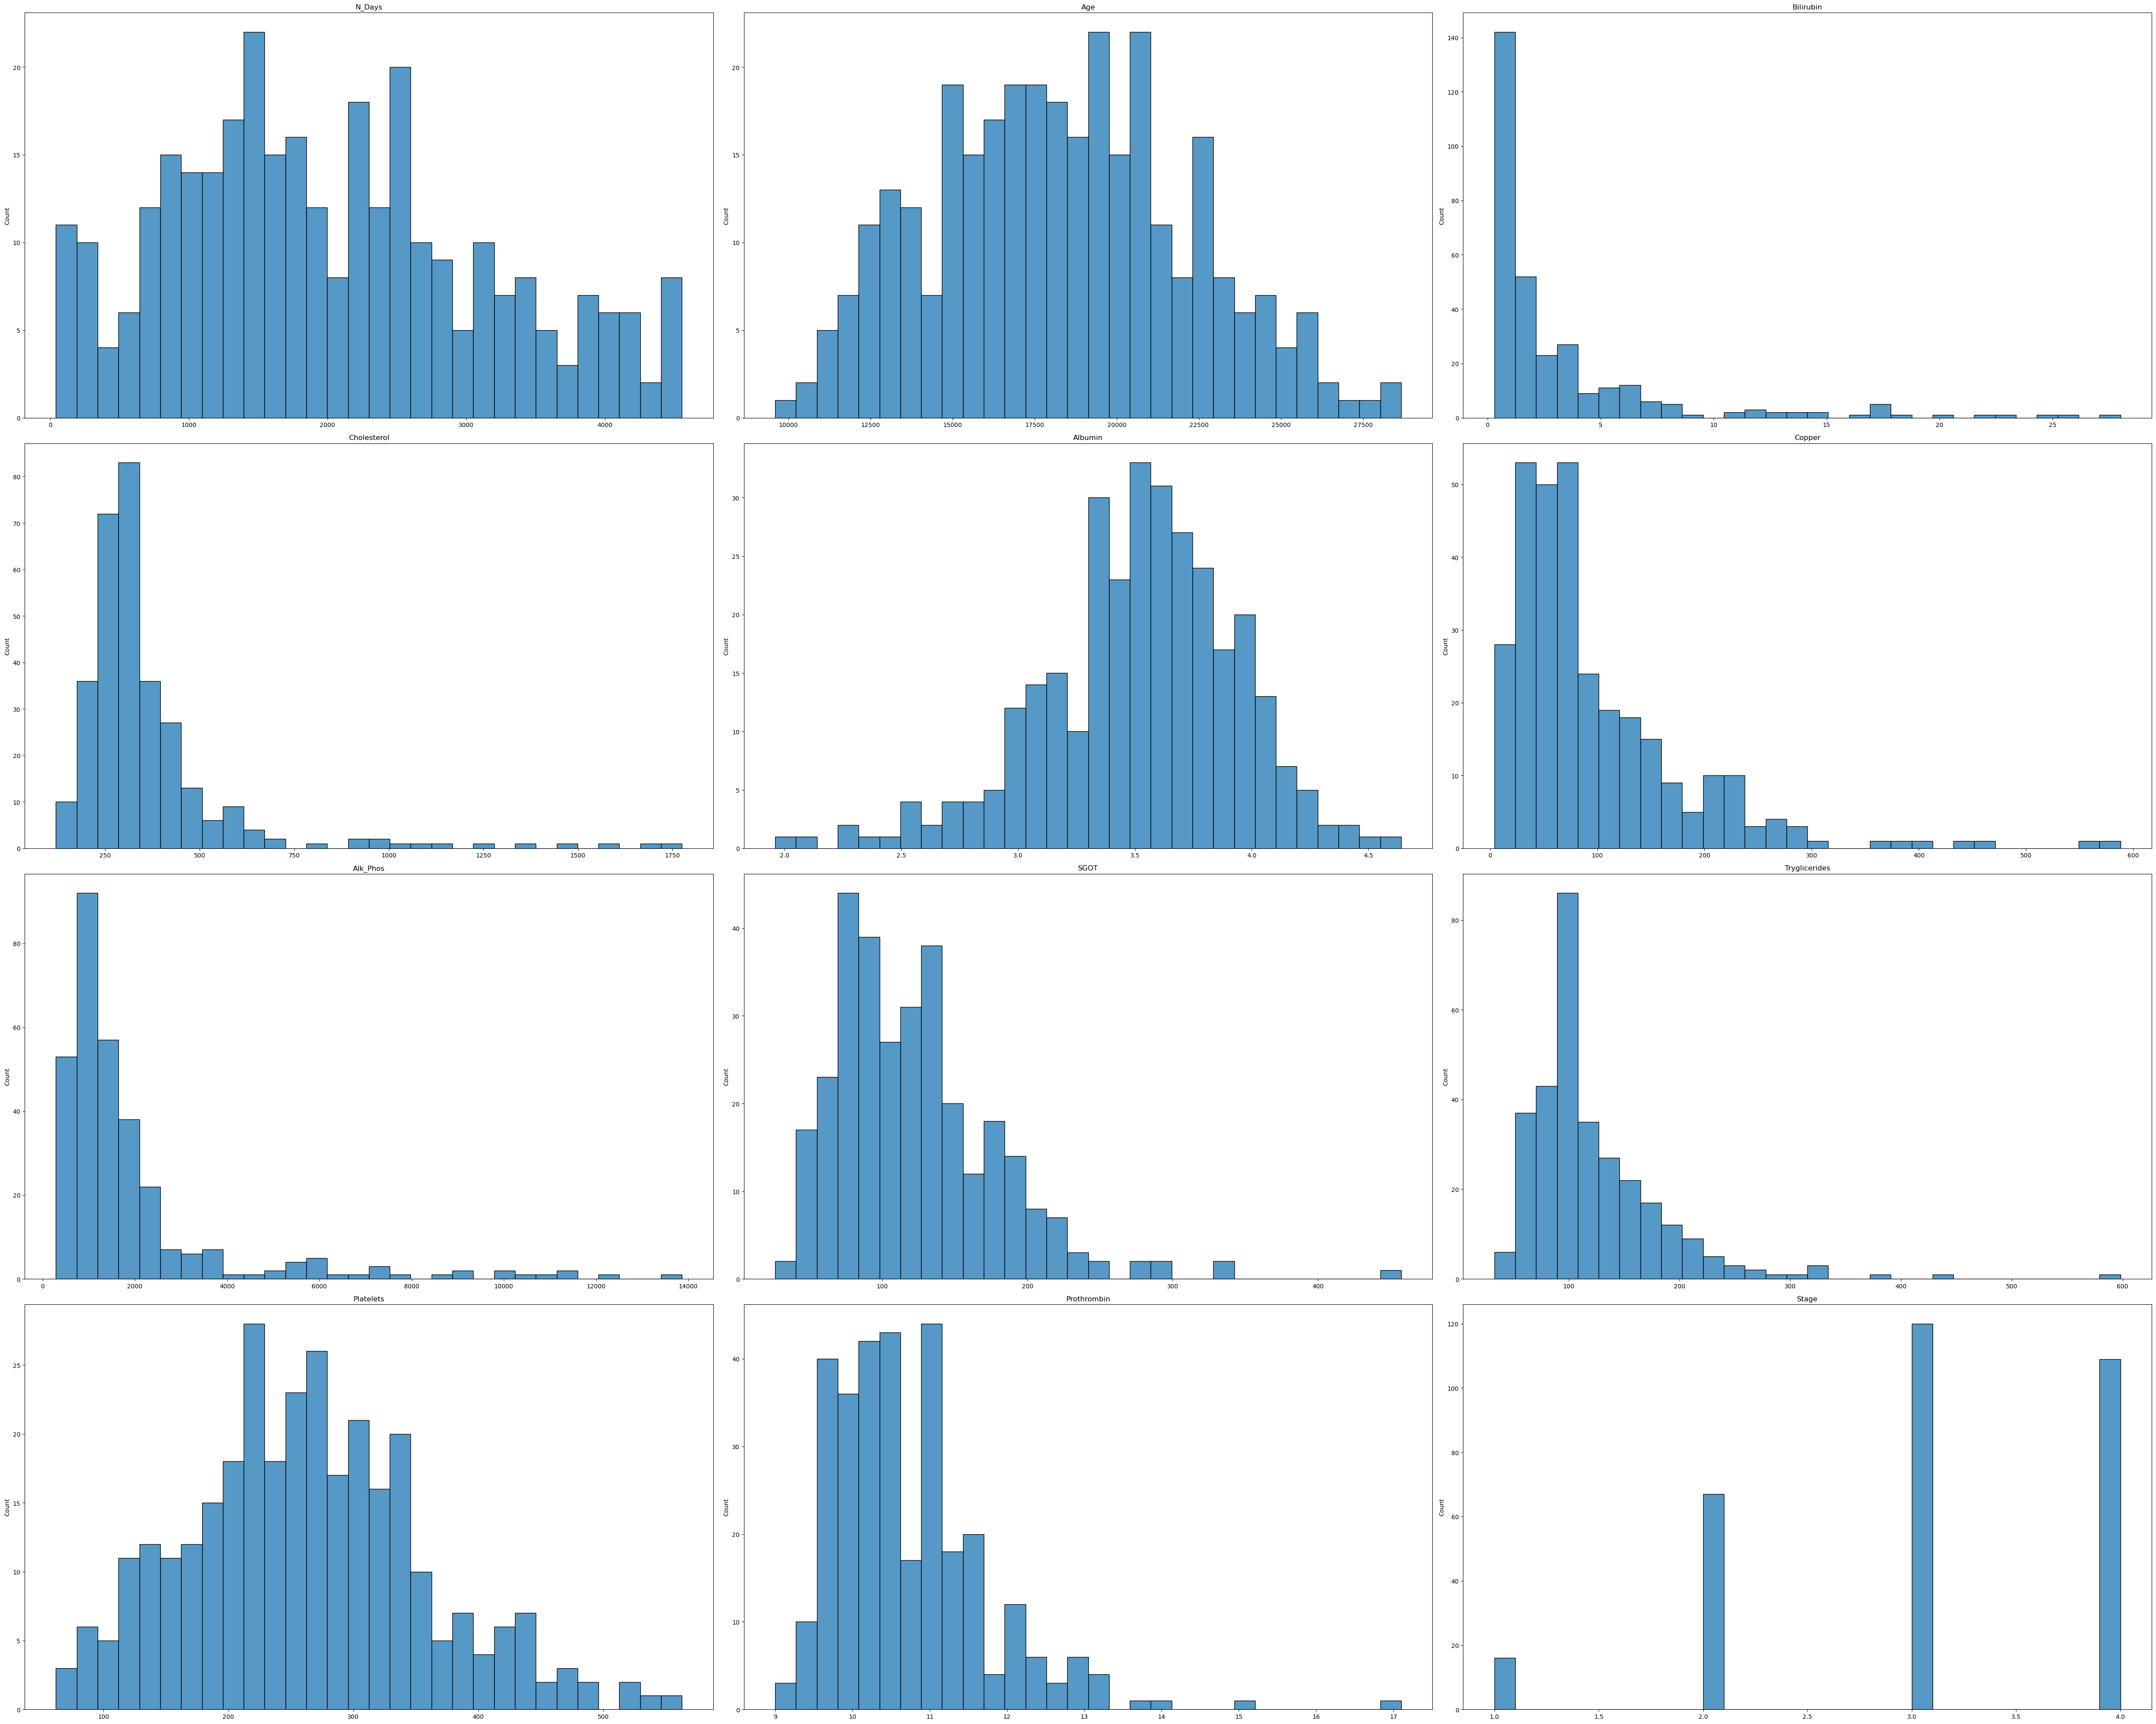

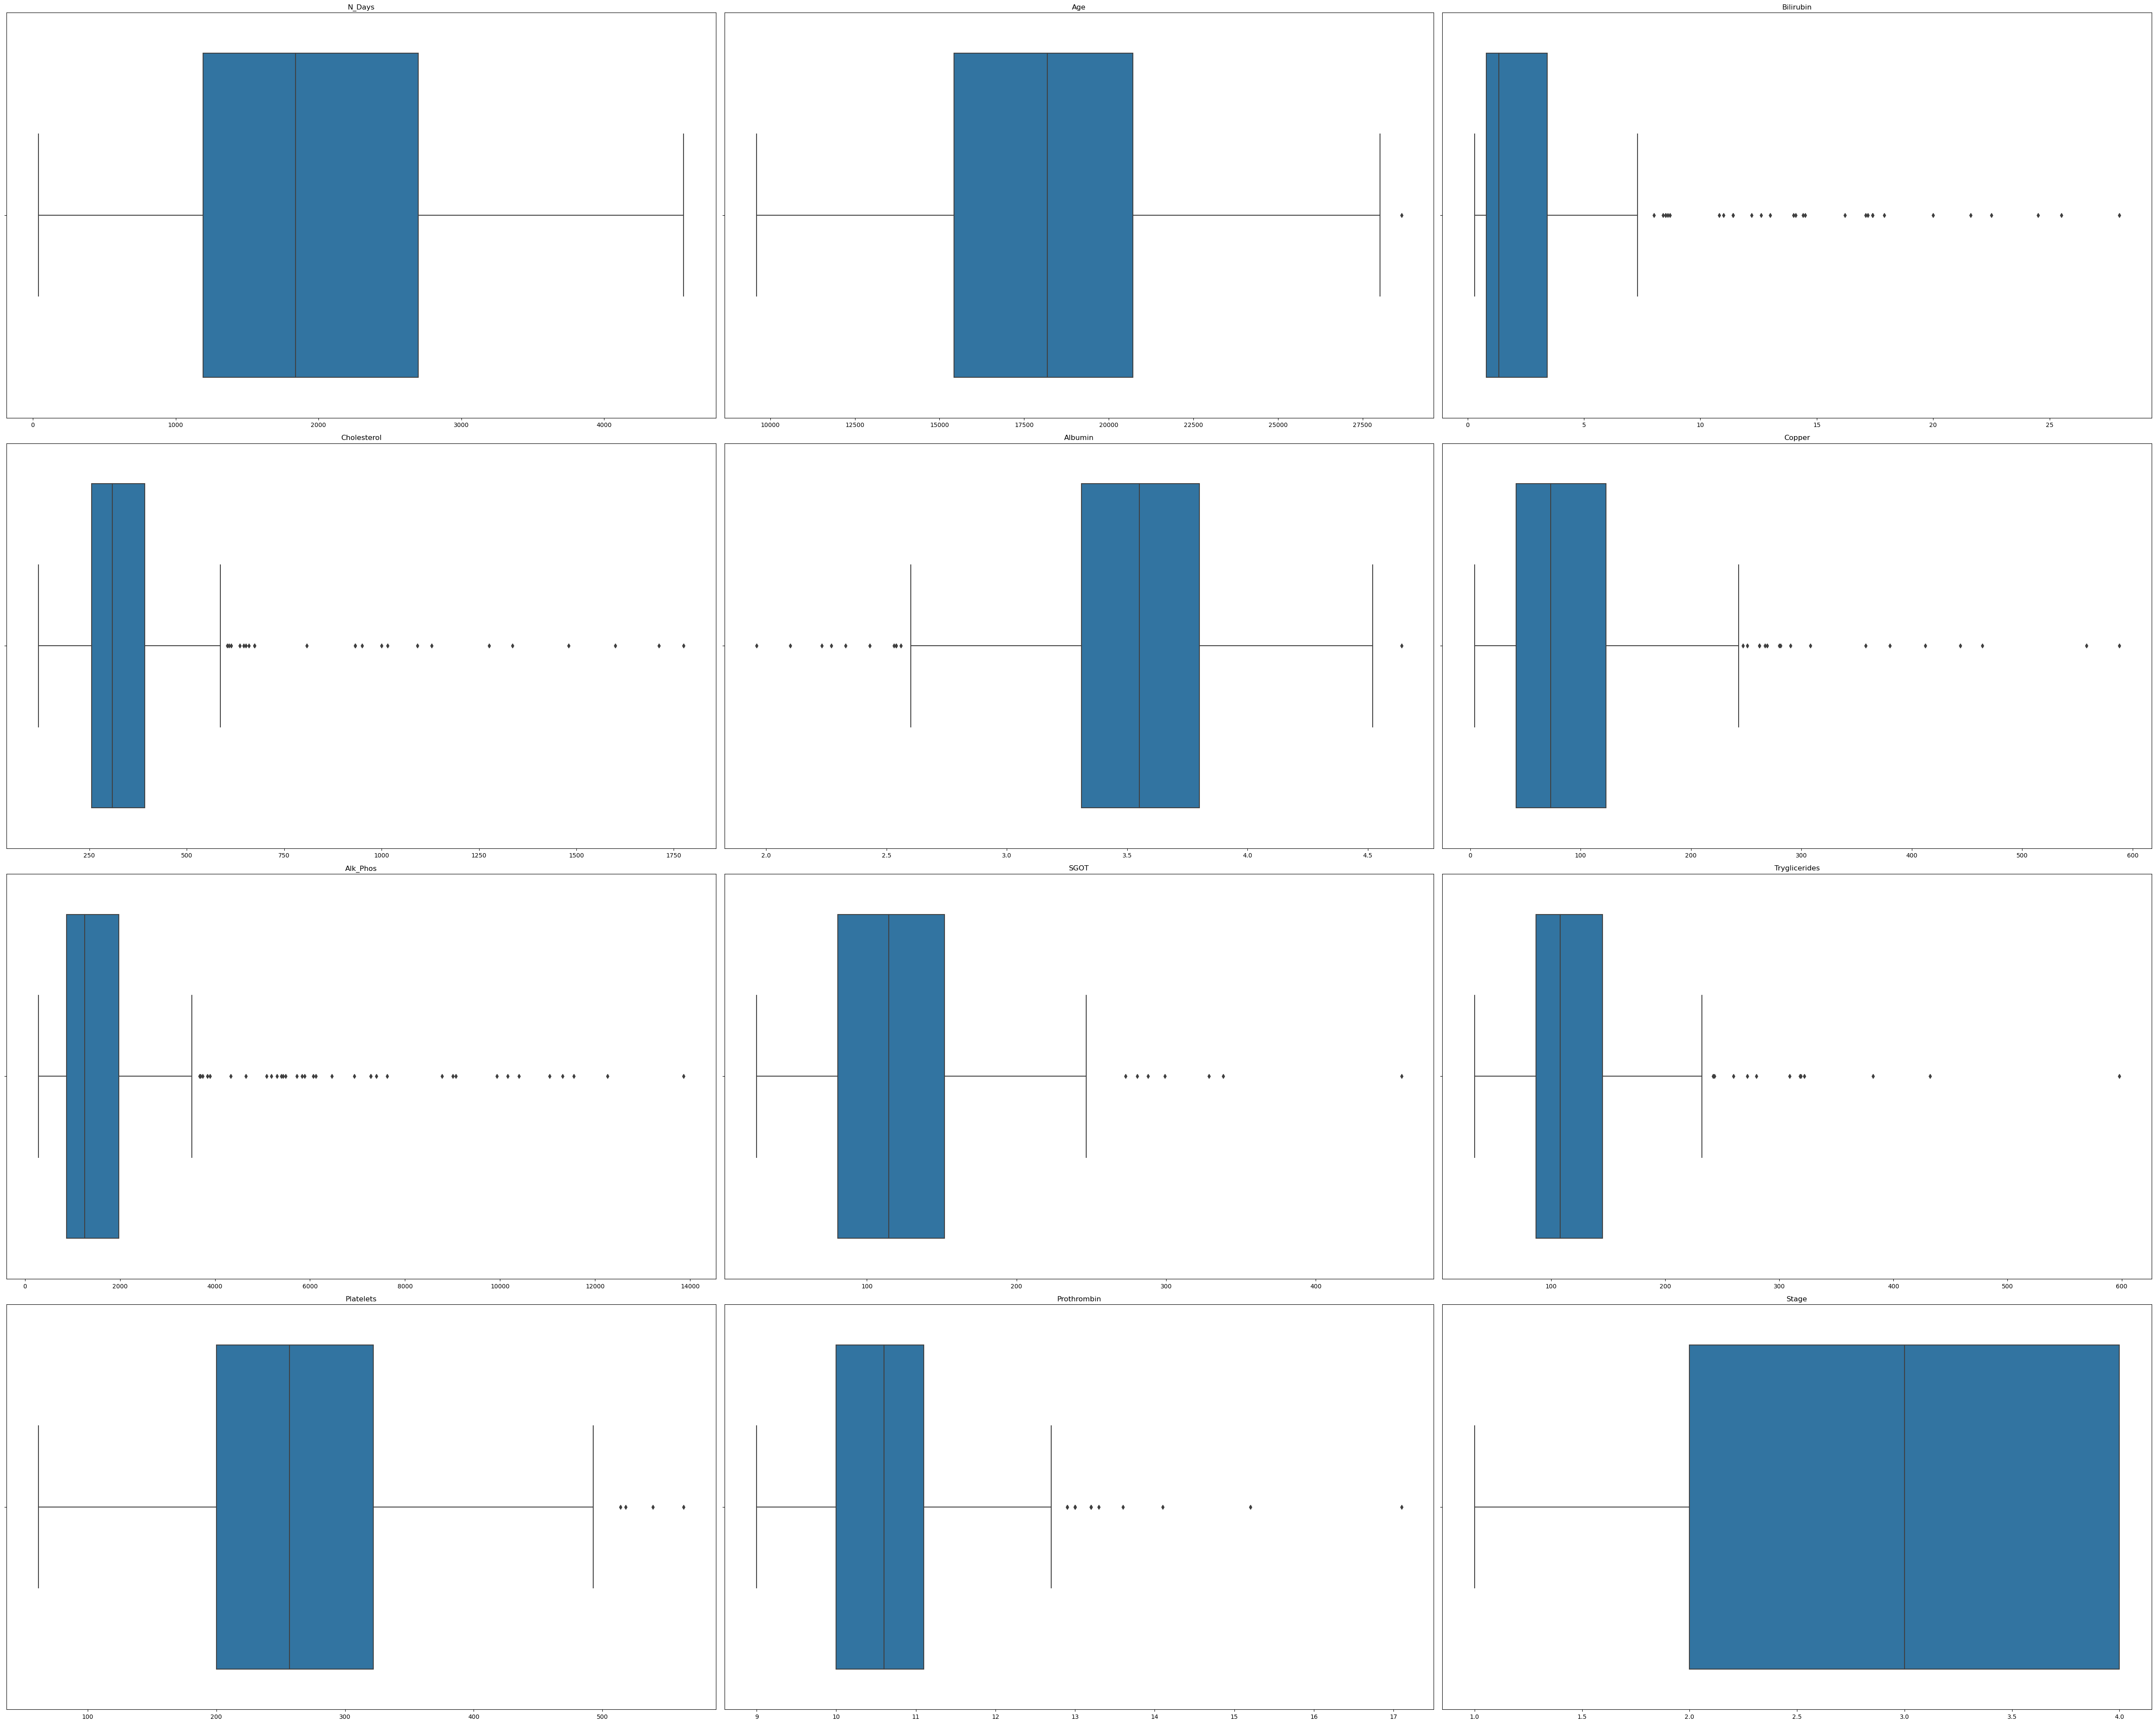

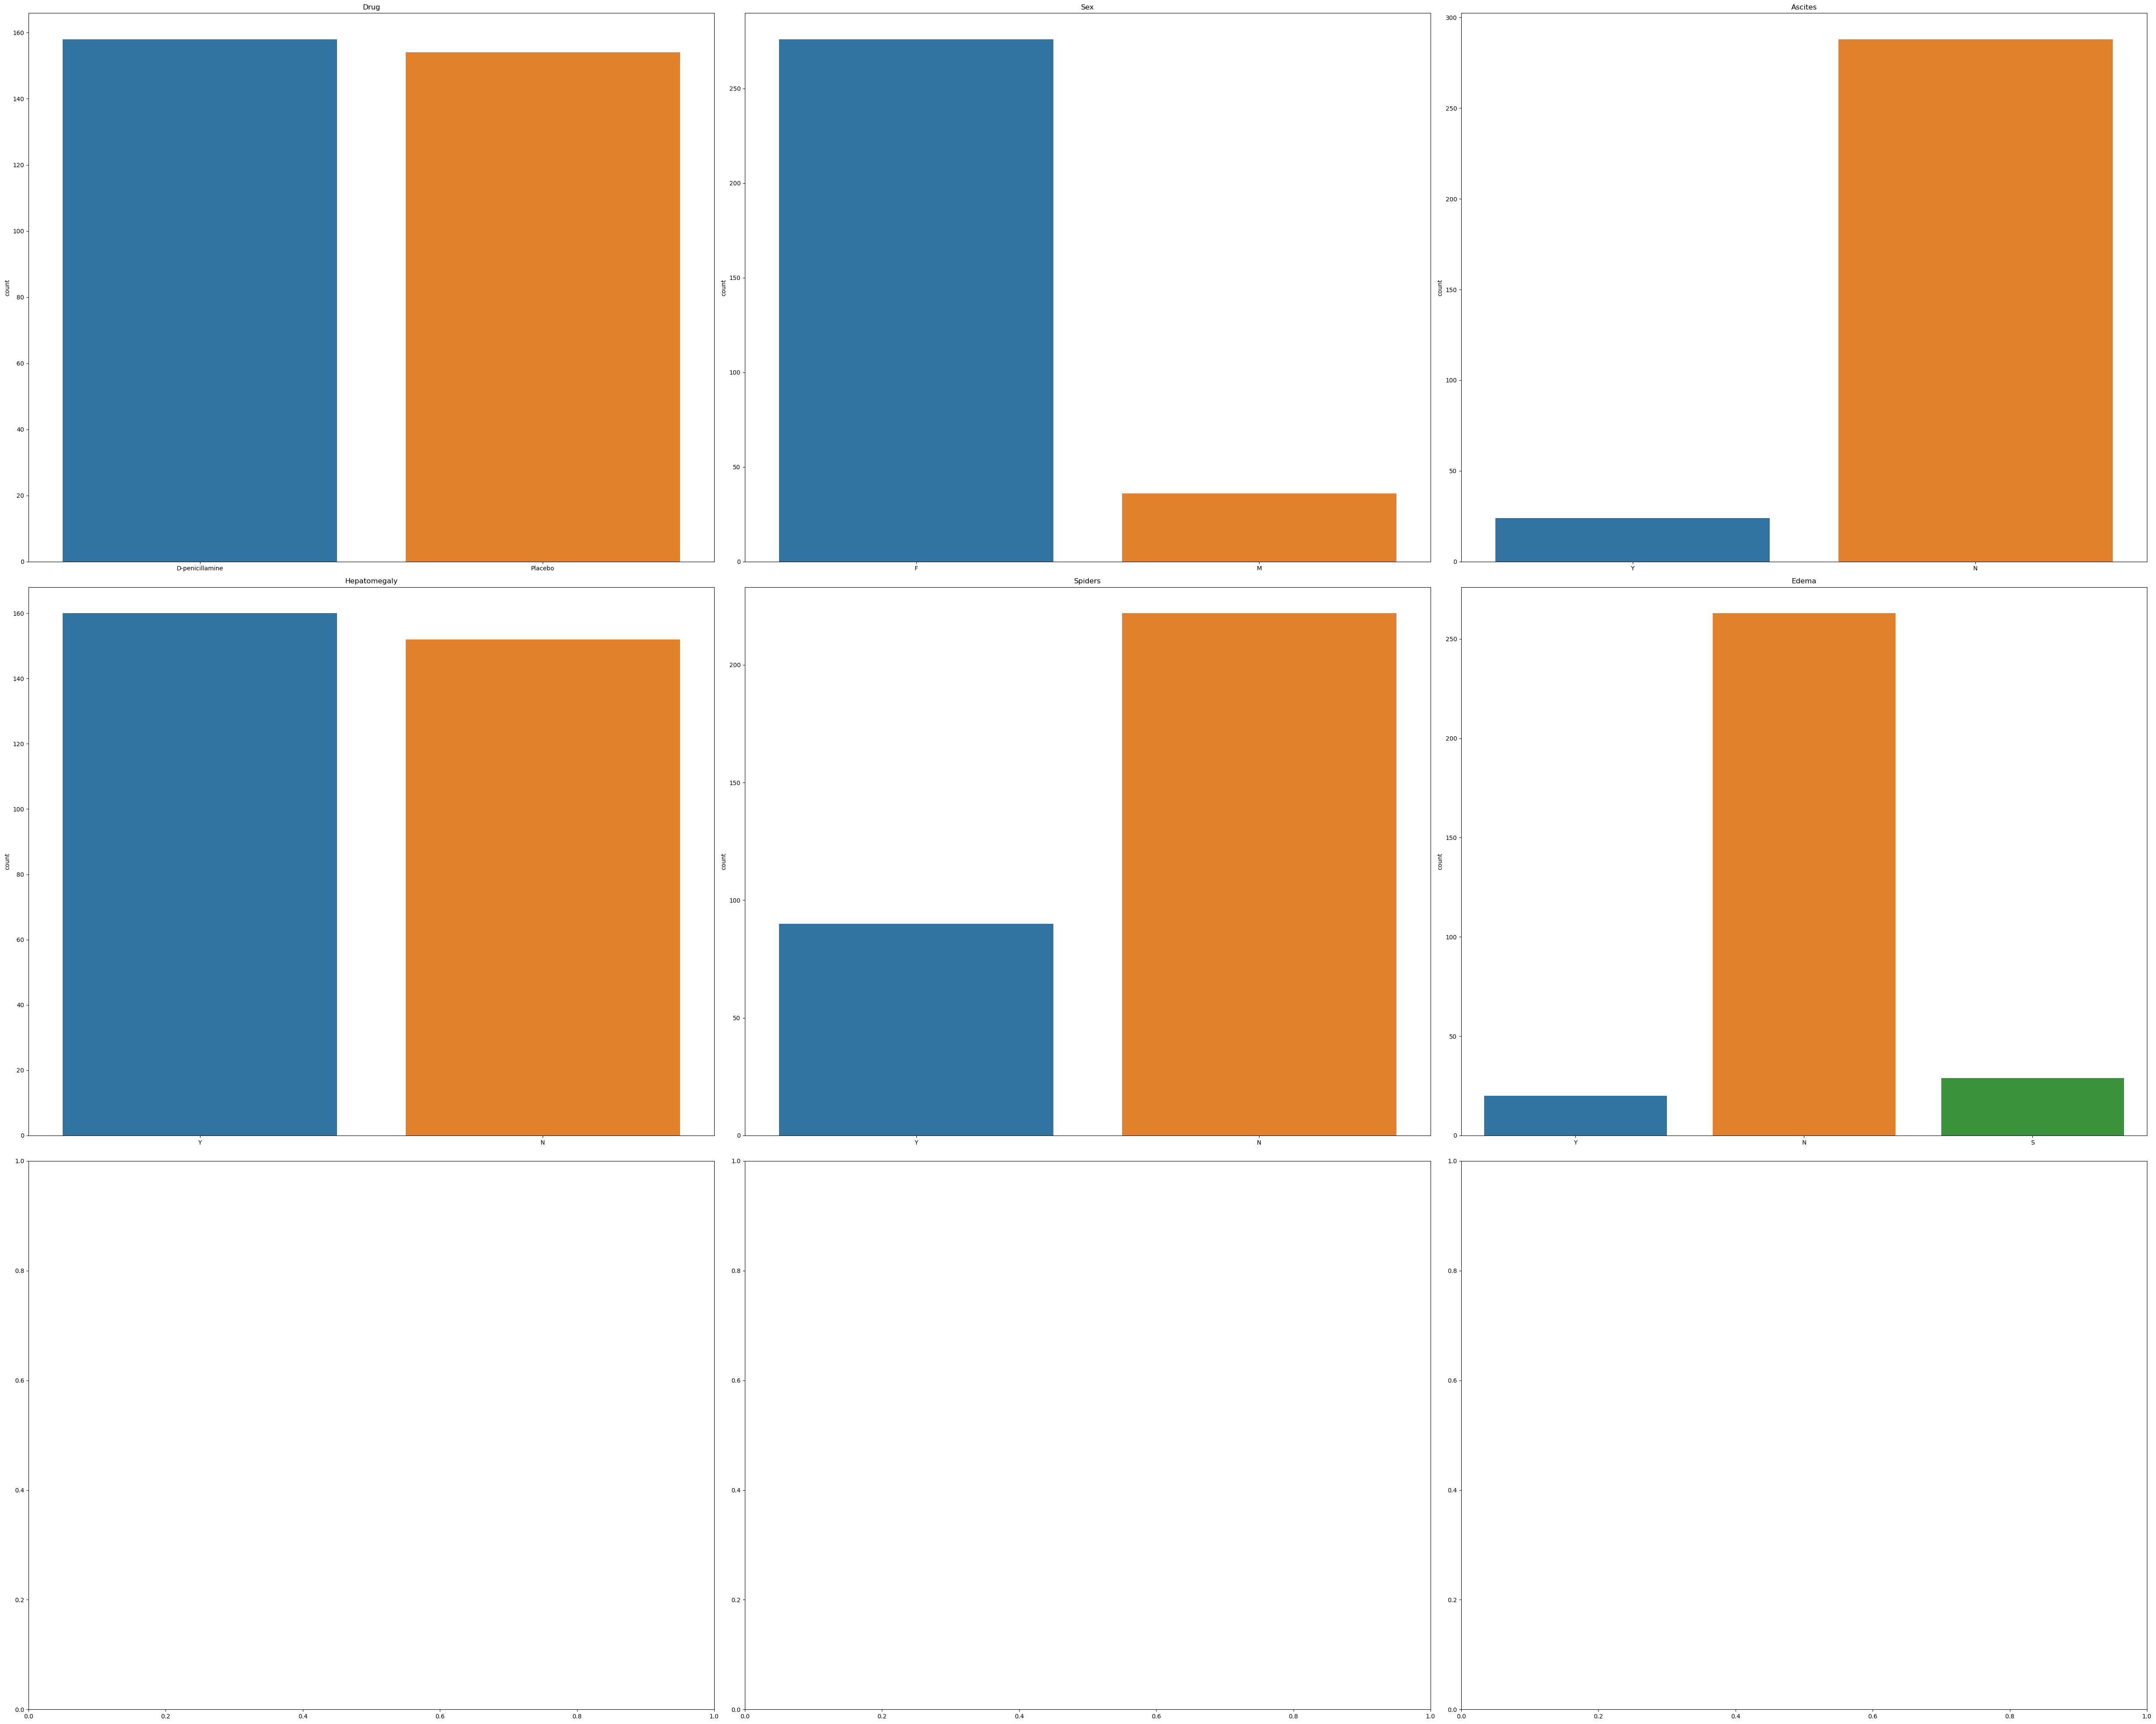

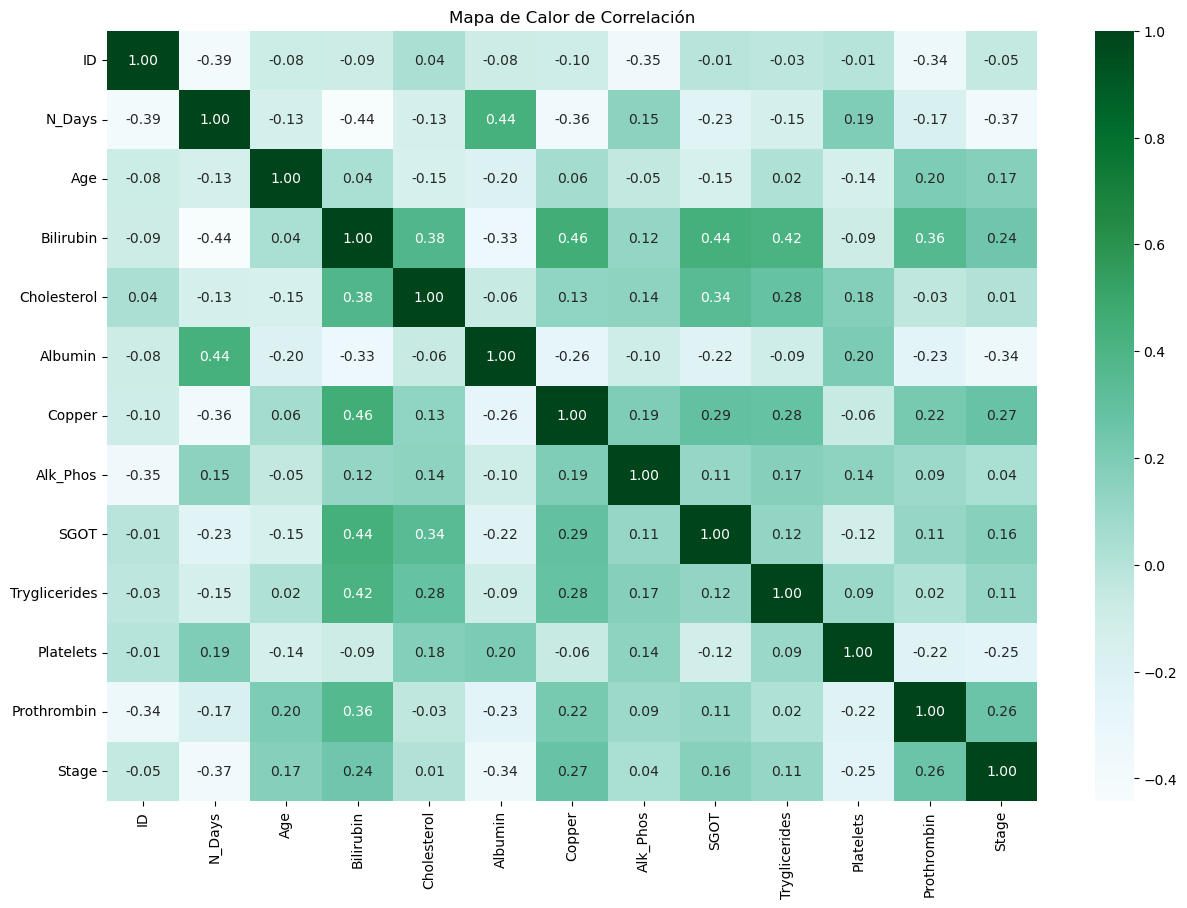

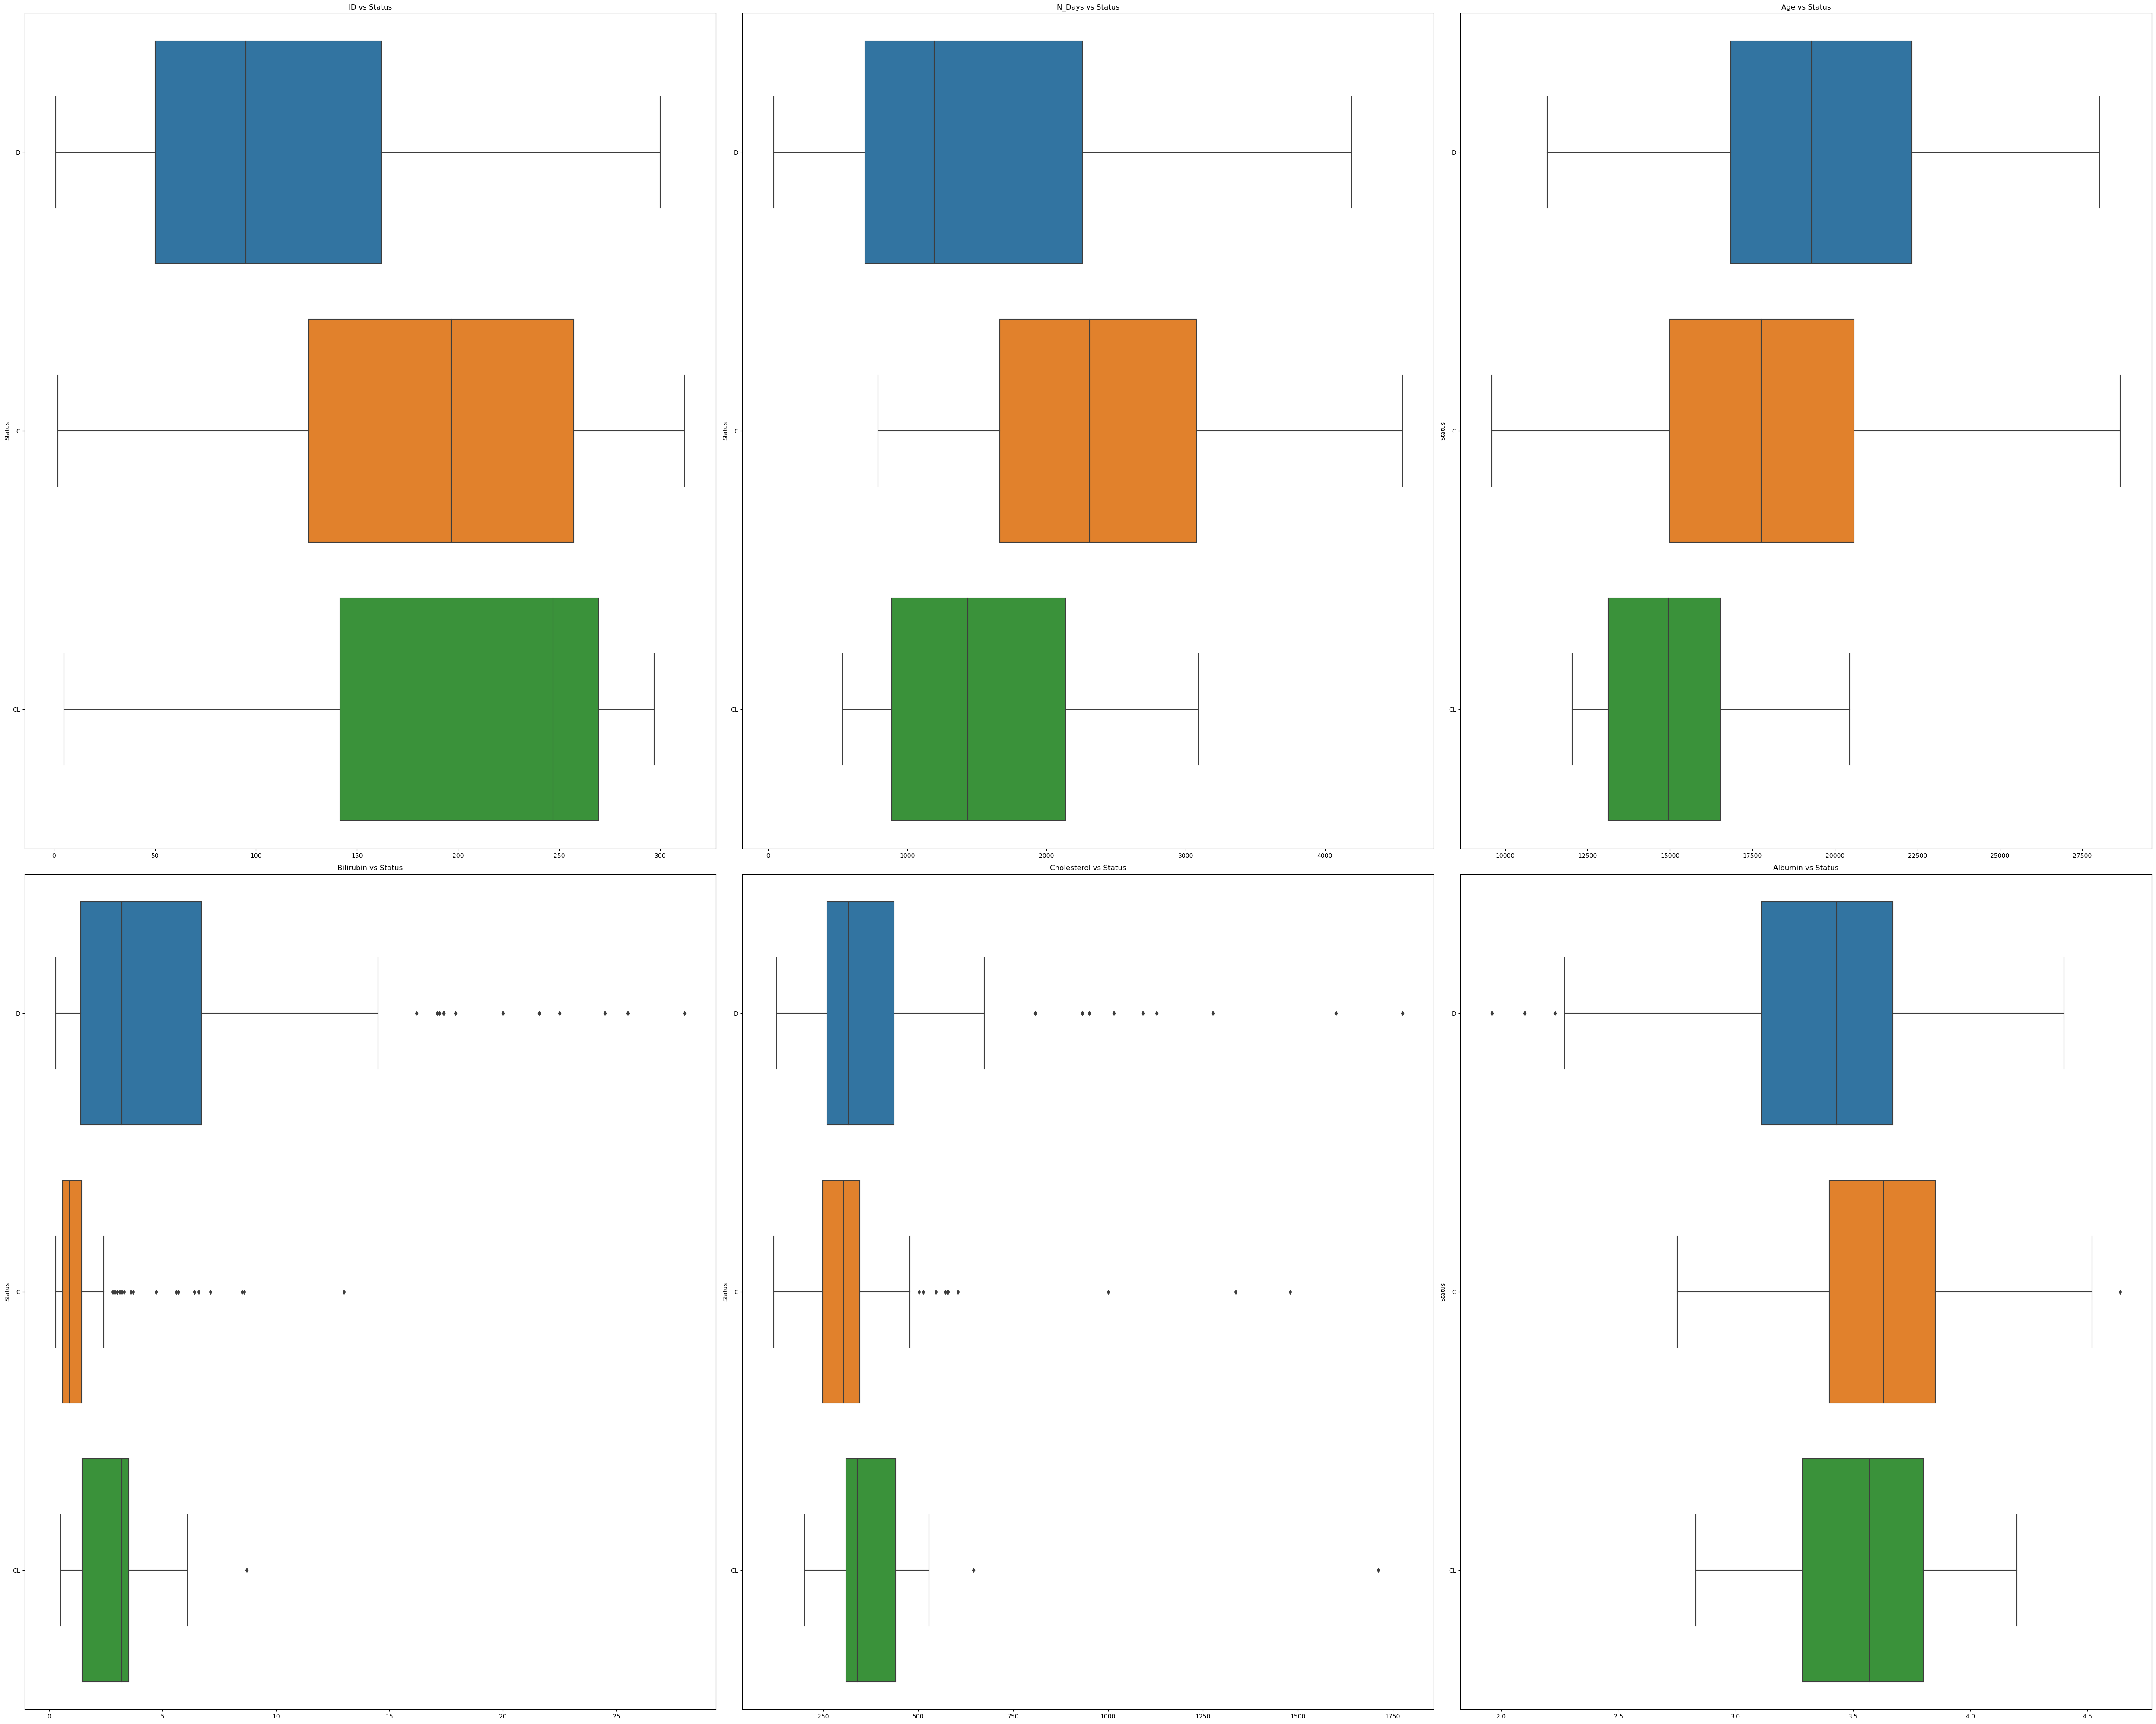

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packag

Mejores hiperparámetros para Regresión Logística: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Mejores hiperparámetros para XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Evaluando el modelo de Regresión Logística en el conjunto de entrenamiento:


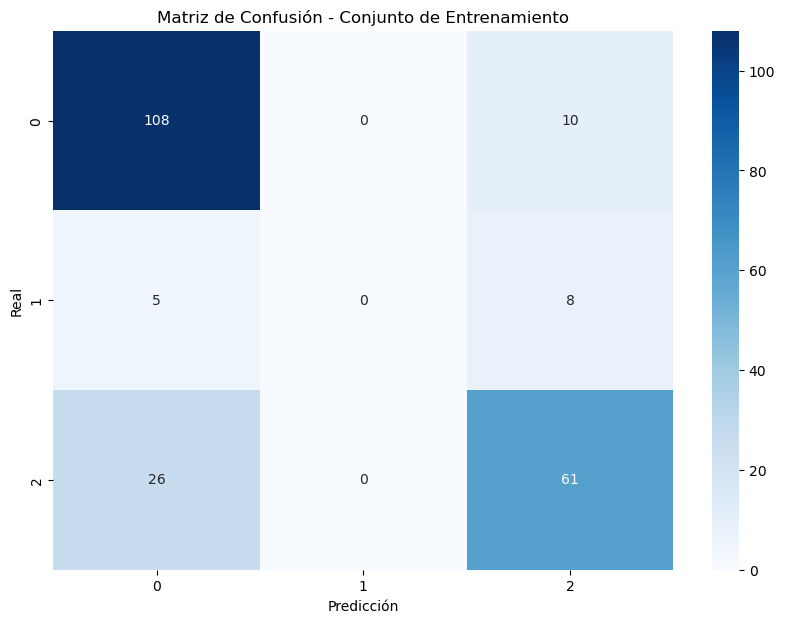

Precisión en el conjunto de entrenamiento: 0.73
Recall en el conjunto de entrenamiento: 0.78
Puntuación F1 en el conjunto de entrenamiento: 0.75

Evaluando el modelo de XGBoost en el conjunto de entrenamiento:


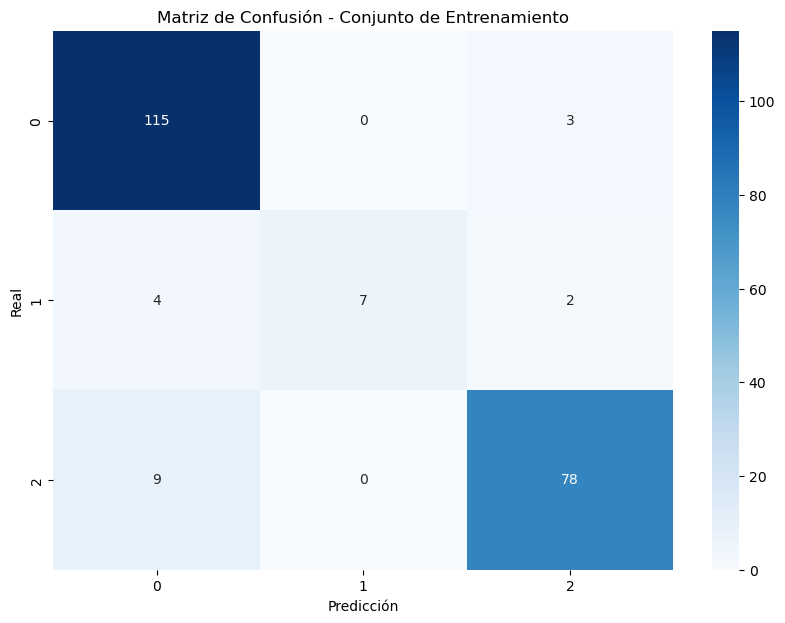

Precisión en el conjunto de entrenamiento: 0.92
Recall en el conjunto de entrenamiento: 0.92
Puntuación F1 en el conjunto de entrenamiento: 0.91
Evaluando el modelo de Regresión Logística en el conjunto de prueba:


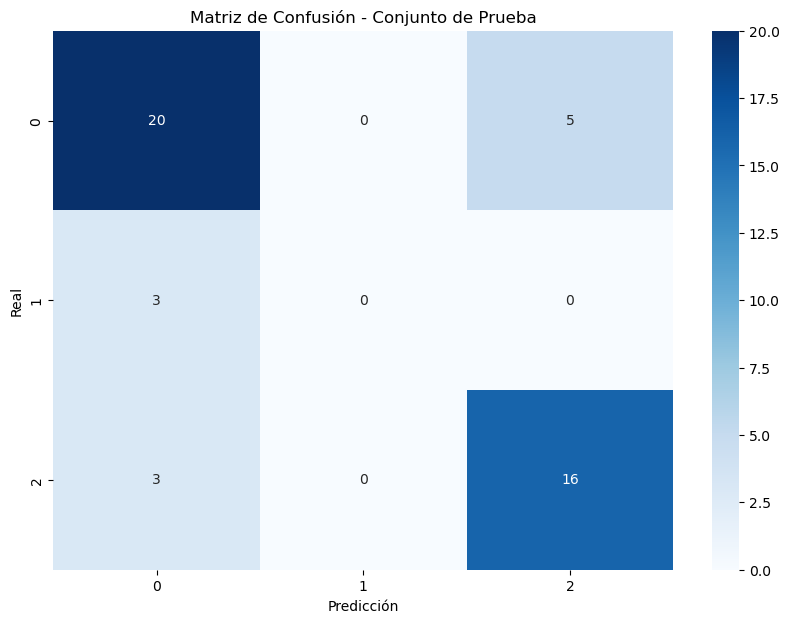

Precisión en el conjunto de prueba: 0.72
Recall en el conjunto de prueba: 0.77
Puntuación F1 en el conjunto de prueba: 0.74

Evaluando el modelo de XGBoost en el conjunto de prueba:


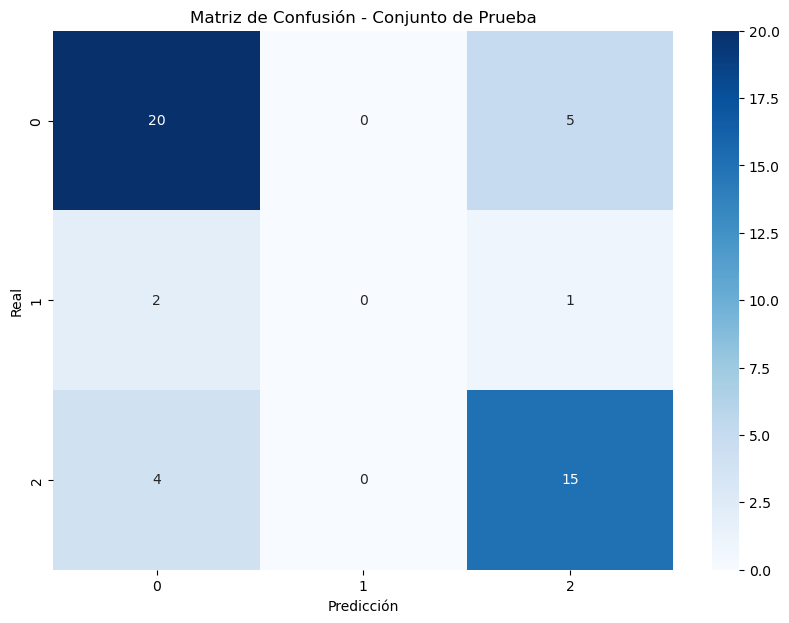

Precisión en el conjunto de prueba: 0.70
Recall en el conjunto de prueba: 0.74
Puntuación F1 en el conjunto de prueba: 0.72
Evaluando el modelo de Regresión Logística en el conjunto de validacion:


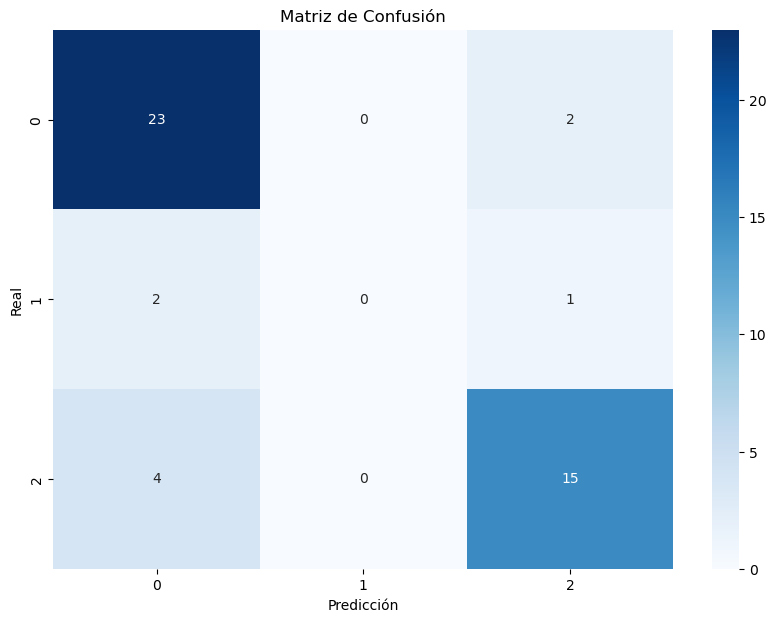

Precisión: 0.76
Recall: 0.81
Puntuación F1: 0.78

Evaluando el modelo de XGBoost en el conjunto de validacion:


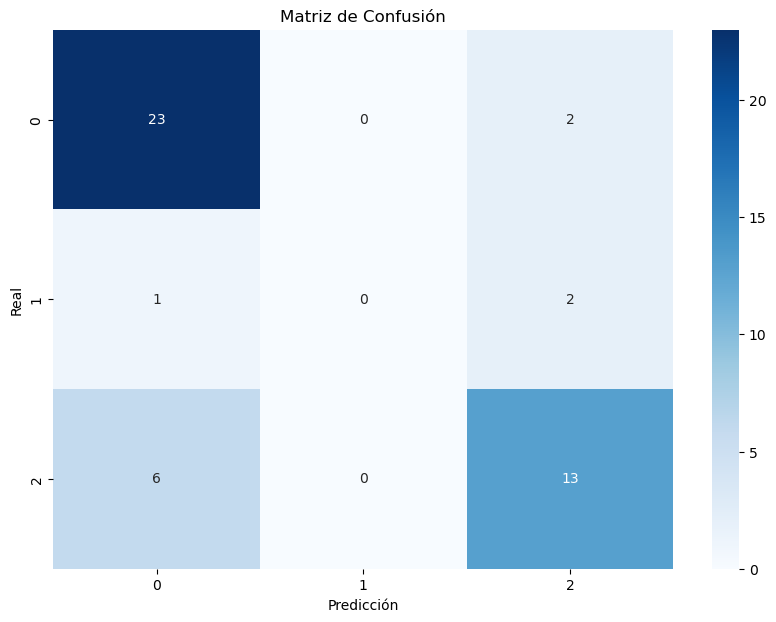

Precisión: 0.72
Recall: 0.77
Puntuación F1: 0.74


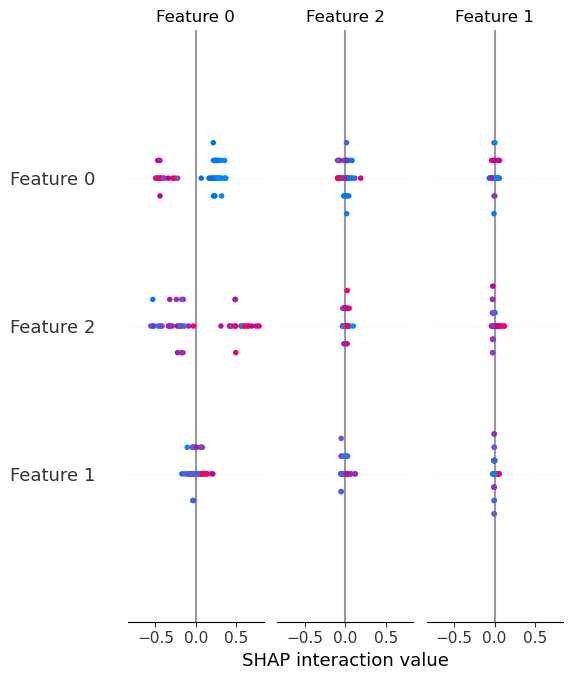

In [14]:
# Paso 1: Cargar y explorar los datos
df = cargar_datos("../../data/cirrhosis.csv")

# Paso 2: Limpiar los datos
df_limpio = limpiar_datos(df)

# Paso 3: Visualizar datos
plot_histograms(df_limpio)
plot_boxplots(df_limpio)
plot_countplots(df_limpio)
plot_correlation_heatmap(df_limpio, target_col="Status")
plot_boxplots_by_target(df_limpio, target_col="Status")

# Paso 4: Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_val, X_test, y_train, y_val, y_test = dividir_datos(df_limpio, target_column="Status")

# Paso 5: Preprocesar los datos
X_train_preprocesado, X_val_preprocesado, X_test_preprocesado, transformador_columnas = preprocesar_datos(X_train, X_val, X_test)

# Paso 6: Optimizar el modelo con GridSearch
mejor_modelo_logistico, mejor_modelo_xgboost = optimizar_modelo(X_train_preprocesado, y_train)

# Paso 7: Evaluar los modelos

# Evaluar el modelo de Regresión Logística en el conjunto de entrenamiento
print("Evaluando el modelo de Regresión Logística en el conjunto de entrenamiento:")
evaluar_modelo_train(mejor_modelo_logistico, X_train_preprocesado, y_train)

# Evaluar el modelo de XGBoost en el conjunto de entrenamiento
print("\nEvaluando el modelo de XGBoost en el conjunto de entrenamiento:")
evaluar_modelo_train(mejor_modelo_xgboost, X_train_preprocesado, y_train)

# Evaluar el modelo de Regresión Logística en el conjunto de prueba
print("Evaluando el modelo de Regresión Logística en el conjunto de prueba:")
evaluar_modelo_test(mejor_modelo_logistico, X_test_preprocesado, y_test)

# Evaluar el modelo de XGBoost en el conjunto de prueba
print("\nEvaluando el modelo de XGBoost en el conjunto de prueba:")
evaluar_modelo_test(mejor_modelo_xgboost, X_test_preprocesado, y_test)

print("Evaluando el modelo de Regresión Logística en el conjunto de validacion:")
evaluar_modelo(mejor_modelo_logistico, X_val_preprocesado, y_val)

print("\nEvaluando el modelo de XGBoost en el conjunto de validacion:")
evaluar_modelo(mejor_modelo_xgboost, X_val_preprocesado, y_val)

# Paso 8: Guardar el modelo optimizado
#guardar_modelo(mejor_modelo, "../../models/cirrhosis_modelo_optimizado.sav")

# Paso 9: Interpretacion del modelo 

# Interpretación con SHAP
interpret_with_shap(mejor_modelo_xgboost, X_test, transformador_columnas)
